## Finding best-fit lines with linear regression

Our prediction is given by $y_1 = X^T_1 w$, how can we find the ws?  
- One way is to find the ws that minimize the error. We define error as the difference between predicted y and the actual y.  
We can write this as
$$\sum_{i=1}^{m}(y_i-x_i^T w)^2$$

We can also write this in matrix notation as $(y-Xw)^T(y-Xw)$. If we take the derivative of this with respect to $w$, we'll get:
$$\frac{\delta((y-Xw)^T(y-Xw))^{'}}{dw} = -X^T(Y-Xw) - (Y-Xw)^{T}X = 0$$

$$\Rightarrow -X^T(Y-Xw) - X^{T}(Y-Xw)= 0 $$

$$\Rightarrow X^T(Y-Xw)=0 $$

$$\Rightarrow \hat w = (X^{T}X)^{-1}X^{T}Y $$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


def loadDataSet(filename):
    numFeat = len(open(filename).readline().split('\t'))-1
    dataMat = []
    labelMat = []
    fr = open(filename)
    for line in fr.readlines():
        lineArr = []
        curLine = line.strip().split('\t')
        for i in range(numFeat):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat, labelMat

In [2]:
def standRegres(xArr, yArr):
    xMat = np.mat(xArr)
    yMat = np.mat(yArr).T
    xTx = xMat.T*xMat
    if np.linalg.det(xTx) == 0.0:
        print("this matrix is singular, cannot do inverse")
        return
    ws = xTx.I * (xMat.T * yMat)
    return ws

ws: [[3.00774324]
 [1.69532264]]


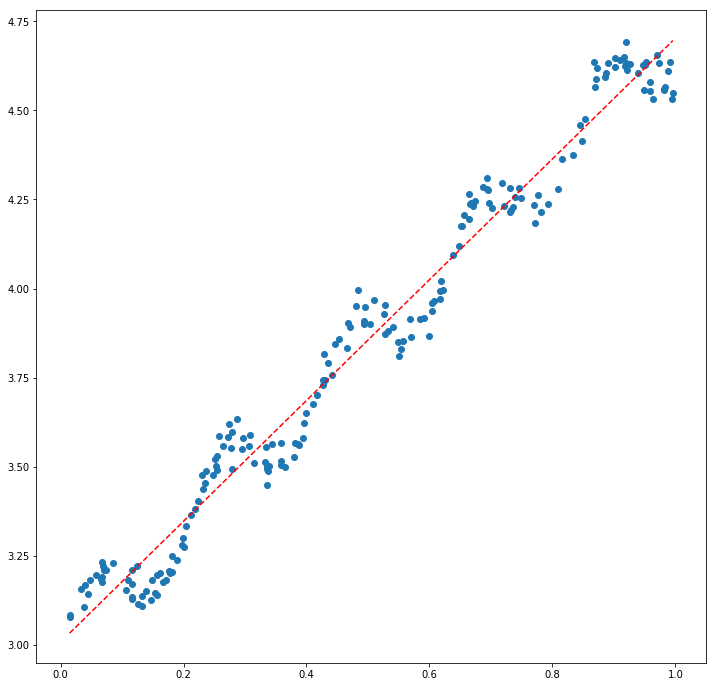

In [3]:
# linear regression test
xArr, yArr = loadDataSet('./src/ex0.txt')
ws = standRegres(xArr, yArr)
print('ws:', ws)
xMat = np.mat(xArr)
yMat = np.mat(yArr)
yHat = xMat*ws

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)

ax.scatter(xMat[:, 1].flatten().A[0], yMat.T[:, 0].flatten().A[0])

xCopy = xMat.copy()
xCopy.sort(0)
yHat = xCopy*ws
ax.plot(xCopy[:, 1], yHat, 'r--')
plt.show()

## Locally weighted linear regression 

$$\hat w = (X^{T}WX)X^{T}W_y$$

$$w(i,i)=exp(\frac{|x^{(i)}-x|}{-2k^2})$$

In [4]:
def lwlr(testPoint, xArr, yArr, k=1.0):
    xMat = np.mat(xArr)
    yMat = np.mat(yArr).T
    m = np.shape(xMat)[0]
    weights = np.mat(np.eye((m)))
    for j in range(m):
        diffMat = testPoint - xMat[j, :]
        weights[j, j] = np.exp(diffMat*diffMat.T/(-2.0*k**2))
    xTx = xMat.T*(weights*xMat)
    if np.linalg.det(xTx) == 0.0:
        print("this matrix is singular, cannot do inverse")
        return
    ws = xTx.I * (xMat.T*(weights*yMat))
    return testPoint*ws

In [5]:
def lwlrTest(testArr, xArr, yArr, k=1.0):
    m = np.shape(testArr)[0]
    yHat = np.zeros(m)
    for i in range(m):
        yHat[i] = lwlr(testArr[i], xArr, yArr, k)
    return yHat

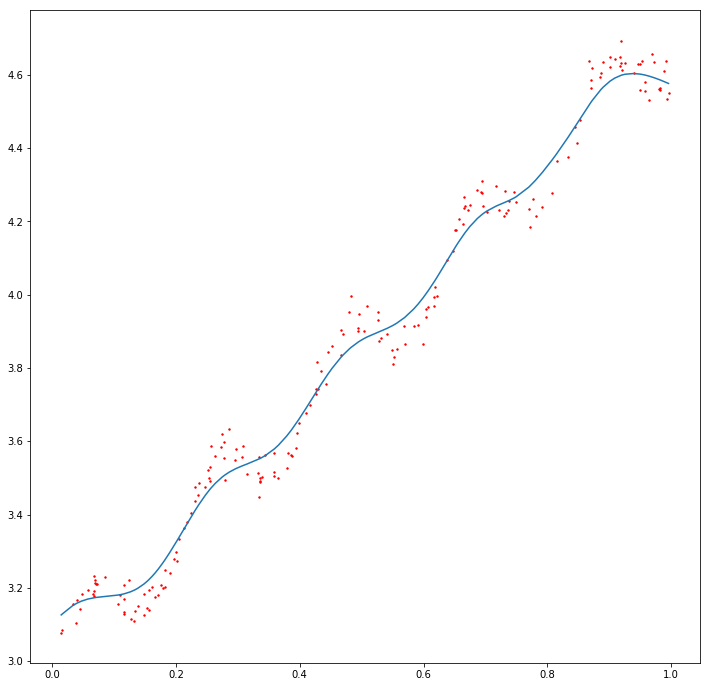

In [6]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)

xArr, yArr = loadDataSet('./src/ex0.txt')
yHat = lwlrTest(xArr, xArr, yArr, 0.05)

xMat = np.mat(xArr)
srtInd = xMat[:, 1].argsort(0)
xSort = xMat[srtInd][:, 0, :]

ax.plot(xSort[:, 1], yHat[srtInd])
ax.scatter(xMat[:, 1].flatten().A[0], np.mat(
    yArr).T.flatten().A[0], s=2, c='red')
plt.show()

## Shrinking coefficients to understand our data
### Ridge regression 

$$\sum_{i=1}^{n}(y_i - \sum_{j=0}^{p}w_j x_{ij})^2 + \lambda \sum_{j=0}^{p} w^2_j $$

$$\hat w = (X^{T}X+\lambda I)^{-1}X^{T}y$$

In [7]:
def ridgeRegres(xMat, yMat, lam=0.2):
    xTx = xMat.T*xMat
    denom = xTx + np.eye(np.shape(xMat)[1])*lam
    if np.linalg.det(denom) == 0.0:
        print("this matrix is singular, cannot do inverse")
        return
    ws = denom.I * (xMat.T*yMat)
    return ws

In [8]:
def ridgeTest(xArr, yArr):
    # convert to matrix
    xMat = np.mat(xArr)
    yMat = np.mat(yArr).T
    # calculate the average value

    ''''''

    yMean = np.mean(yMat, axis=0)
    yMat = yMat - yMean
    xMeans = np.mean(xMat, axis=0)
    xVar = np.var(xMat, 0)
    xMat = (xMat - xMeans)/xVar

    numTestPts = 30
    wMat = np.zeros((numTestPts, np.shape(xMat)[1]))
    for i in range(numTestPts):
        ws = ridgeRegres(xMat, yMat, np.exp(i-10))
        wMat[i, :] = ws.T
    return wMat

weights_ridge/weights_ols =  [[0.99999987 0.99999964]] n/(n+lambda) =  0.9999997730004027
weights_ridge/weights_ols =  [[0.99999965 0.99999903]] n/(n+lambda) =  0.9999993829513604
weights_ridge/weights_ols =  [[0.99999905 0.99999737]] n/(n+lambda) =  0.9999983226896738
weights_ridge/weights_ols =  [[0.9999974  0.99999286]] n/(n+lambda) =  0.9999954406109604
weights_ridge/weights_ols =  [[0.99999295 0.9999806 ]] n/(n+lambda) =  0.99998760639272
weights_ridge/weights_ols =  [[0.99998082 0.99994728]] n/(n+lambda) =  0.9999663113999645
weights_ridge/weights_ols =  [[0.99994785 0.99985676]] n/(n+lambda) =  0.999908430191354
weights_ridge/weights_ols =  [[0.99985813 0.99961112]] n/(n+lambda) =  0.9997511266115428
weights_ridge/weights_ols =  [[0.99961355 0.99894652]] n/(n+lambda) =  0.9993237811651547
weights_ridge/weights_ols =  [[0.99894361 0.99716227]] n/(n+lambda) =  0.9981639799642663
weights_ridge/weights_ols =  [[0.99708795 0.99246704]] n/(n+lambda) =  0.9950248756218906
weights_ridge

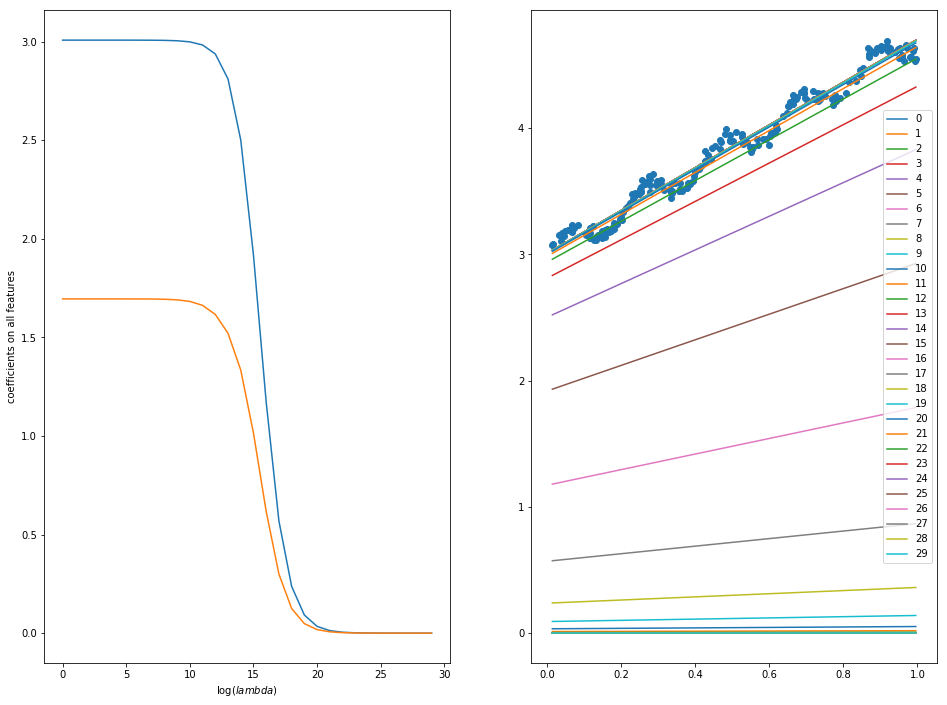

[2.8578300342875185, 2.718281828459045]
[2.830980702523687, 1.0]
[2.7641140915445868, 0.36787944117144233]
[2.6132606533782825, 0.1353352832366127]
[2.312979219022624, 0.049787068367863944]
[1.7803873810749549, 0.018315638888734182]
[1.0294249858086588, 0.006737946999085467]
[0.38142327486222366, 0.0024787521766663585]
[0.08976982623260538, 0.0009118819655545162]
[0.015596859171960763, 0.00033546262790251185]
[0.0023337893005025727, 0.00012340980408667953]
[0.0003281618476884674, 4.539992976248485e-05]
[4.504980614225949e-05, 1.670170079024566e-05]
all w^2 less than 1/lambda?: False


In [61]:
abX, abY = loadDataSet('./src/ex0.txt')

weights_OLS = standRegres(abX, abY)
xMat = np.mat(abX)
yMat = np.mat(abY).T
numTestPts = 30
testLam = []
wMat = np.zeros((numTestPts, np.shape(xMat)[1]))
for i in range(numTestPts):
    ws = ridgeRegres(xMat, yMat, np.exp(i-10))
    testLam.append(np.exp(i-10))
    wMat[i, :] = ws.T
ridgeWeights = wMat.copy()
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(121)
ax1.plot(ridgeWeights)
plt.xlabel('$\log (lambda)$')
plt.ylabel('coefficients on all features')

ax2 = fig.add_subplot(122)
ax2.scatter(xMat[:, 1].flatten().A[0], yMat[:, 0].flatten().A[0])
xCopy = xMat.copy()
xCopy.sort(0)

maxDiff = 0
for i in range(np.shape(ridgeWeights)[0]):
    yHat = (ridgeWeights[i]) * (xCopy.T)
    ax2.plot(xCopy[:, 1], yHat.T,label=i)
    print("weights_ridge/weights_ols = ",(ridgeWeights[i].T)/(weights_OLS.T),'n/(n+lambda) = ',len(abY)/(testLam[i]+len(abY)))
    maxVal = ((ridgeWeights[i].T)/(weights_OLS.T)).getA()[0].max()
    minVal = ((ridgeWeights[i].T)/(weights_OLS.T)).getA()[0].min()
    if maxVal-minVal > maxDiff:
        maxDiff = maxVal-minVal
print('maxDiff = ', maxDiff)
plt.legend()
plt.show()

outputs = [[(a[1:]**2).sum()]+[1/b] for a, b in zip(ridgeWeights, testLam)]
flag = True
for i in range(len(outputs)):
    if outputs[i][0]>outputs[i][1]:
        print(outputs[i])
        flag=False
print('all w^2 less than 1/lambda?:',flag)

### illustrate the L2 regularization

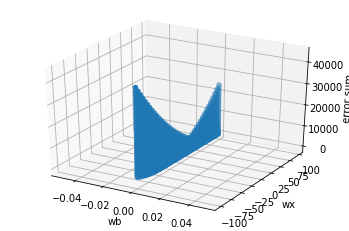

In [22]:
from mpl_toolkits.mplot3d import Axes3D
abX, abY = loadDataSet('./src/illustrate.txt')

xMat = np.mat(abX)
yMat = np.mat(abY).T

xCopy = xMat.copy()
xCopy.sort(0)

dataRange = np.arange(-100, 100, 5)
wMat = []
yHat = []
for i in dataRange:
    for j in dataRange:
        ws = [0, i, j]
        wMat.append(ws)
        yHat.append(np.power((yMat - xCopy*(np.array(ws).reshape((3, 1)))), 2).sum(axis=0))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.array(wMat)[:, 0], np.array(wMat)[:, 1], np.array(yHat))

ax.set_xlabel('wb')
ax.set_ylabel('wx')
ax.set_zlabel('error sum')
plt.show()

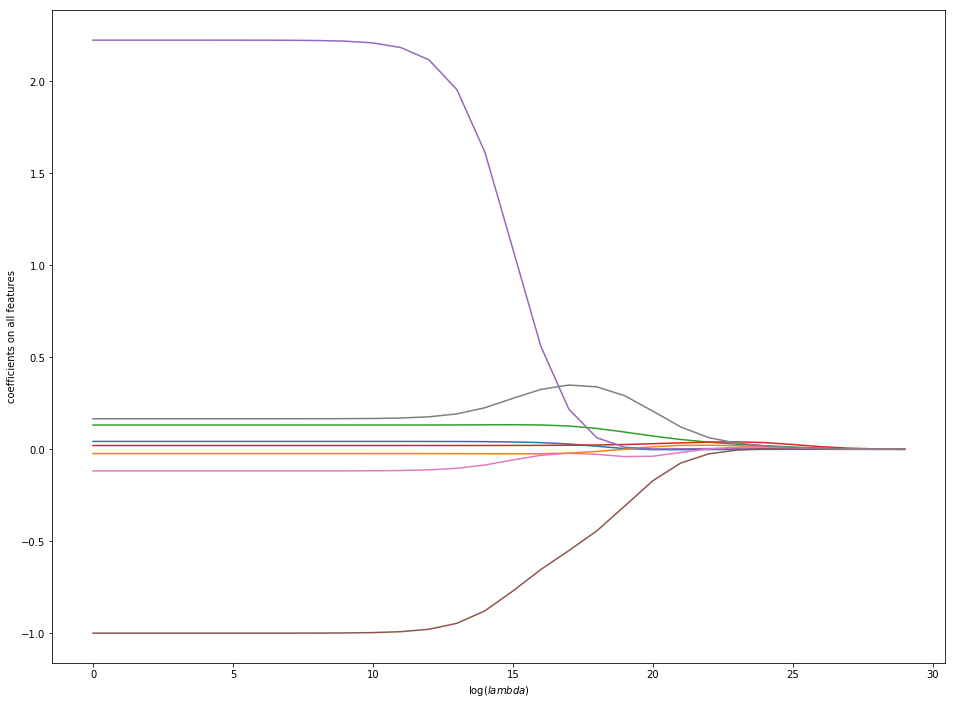

In [11]:
abX, abY = loadDataSet('./src/abalone.txt')
ridgeWeights = ridgeTest(abX, abY)
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(ridgeWeights)
plt.xlabel('$\log (lambda)$')
plt.ylabel('coefficients on all features')
plt.show()

In [12]:
def rssError(yArr, yHatArr):  # yArr and yHatArr both need to be arrays
    return ((yArr-yHatArr)**2).sum()

In [13]:
def regularize(xMat):  # regularize by columns
    inMat = xMat.copy()
    inMeans = np.mean(inMat, 0)  # calc mean then subtract it off
    inVar = np.var(inMat, 0)  # calc variance of Xi then divide by it
    inMat = (inMat - inMeans)/inVar
    return inMat

In [14]:
def stageWise(xArr, yArr, eps=0.0, numIt=100):
    xMat = np.mat(xArr)
    yMat = np.mat(yArr).T
    yMean = np.mean(yMat, axis=0)
    yMat = yMat - yMean
    xMat = regularize(xMat)
    m, n = np.shape(xMat)
    returnMat = np.zeros((numIt, n))
    ws = np.zeros((n, 1))
    wsTest = ws.copy()
    wsMax = ws.copy
    for i in range(numIt):
        # print(ws.T)
        lowestError = np.inf
        for j in range(n):
            for sign in [-1, 1]:
                wsTest = ws.copy()
                wsTest[j] += eps*sign
                yTest = xMat*wsTest
                rssE = rssError(yMat.A, yTest.A)
                if rssE < lowestError:
                    lowestError = rssE
                    wsMax = wsTest
        ws = wsMax.copy()
        returnMat[i, :] = ws.T
    return returnMat

In [15]:
xArr, yArr = loadDataSet('./src/abalone.txt')
returnMat = stageWise(xArr, yArr, 0.01, 200)
print(returnMat)

[[ 0.    0.    0.   ...  0.    0.    0.  ]
 [ 0.    0.    0.   ...  0.    0.    0.  ]
 [ 0.    0.    0.   ...  0.    0.    0.  ]
 ...
 [ 0.05  0.    0.09 ... -0.64  0.    0.36]
 [ 0.04  0.    0.09 ... -0.64  0.    0.36]
 [ 0.05  0.    0.09 ... -0.64  0.    0.36]]


In [16]:
returnMat = stageWise(xArr, yArr, 0.001, 5000)
print(returnMat[:5])
print(returnMat[-5:-1])

[[0.    0.    0.    0.001 0.    0.    0.    0.   ]
 [0.    0.    0.    0.002 0.    0.    0.    0.   ]
 [0.    0.    0.    0.003 0.    0.    0.    0.   ]
 [0.    0.    0.    0.004 0.    0.    0.    0.   ]
 [0.    0.    0.    0.005 0.    0.    0.    0.   ]]
[[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]
 [ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]
 [ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]
 [ 0.044 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]


### The lasso
The ridge regression gives the following constraint:  
$$\sum_{k=1}^{n}|w_k|^2\leq \lambda$$
This means that the sum of the squares of all our weights has to be less than or equal to $\lambda$
- [ ] how to prove this

The lasso impses a different constraint on the weight:
$$\sum_{k=1}^{n}|w_k|\leq \lambda$$

### Forward stagewise regression

In [17]:
def stageWise(xArr, yArr, eps=0.01, numIt=100):
    # normalize the features to unit variance
    xMat = np.mat(xArr)
    yMat = np.mat(yArr).T
    yMean = np.mean(yMat, 0)
    yMat = yMat - yMean
    xMat = regularize(xMat)

    m, n = np.shape(xMat)
    ws = np.zeros((n, 1))
    wsTest = ws.copy()
    wsMax = ws.copy()
    for i in range(numIt):
        print(ws.T)
        lowestError = np.inf
        for j in range(n):
            for sign in [-1, 1]:
                wsTest = ws.copy()
                wsTest[j] += eps*sign
                yTest = xMat * wsTest
                rssE = rssError(yMat.A, yTest.A)
                if rssE < lowestError:
                    lowestError = rssE
                    wsMax = wsTest
            ws = wsMax.copy()
            returnMat[i, :] = ws.T
        return returnMat

In [18]:
xArr, yArr = loadDataSet('./src/abalone.txt')
returnMat = stageWise(xArr, yArr, 0.01, 200)
print('returnMat:\n', returnMat)

[[0. 0. 0. 0. 0. 0. 0. 0.]]
returnMat:
 [[-0.01   0.01   0.01  ...  0.01   0.01   0.01 ]
 [ 0.     0.     0.    ...  0.     0.     0.   ]
 [ 0.     0.     0.    ...  0.     0.     0.   ]
 ...
 [ 0.043 -0.011  0.12  ... -0.963 -0.105  0.187]
 [ 0.044 -0.011  0.12  ... -0.963 -0.105  0.187]
 [ 0.043 -0.011  0.12  ... -0.963 -0.105  0.187]]


In [19]:
returnMat = stageWise(xArr, yArr, 0.001, 5000)
print('returnMat:\n', returnMat)

[[0. 0. 0. 0. 0. 0. 0. 0.]]
returnMat:
 [[-0.001  0.001  0.001 ...  0.001  0.001  0.001]
 [ 0.     0.     0.    ...  0.     0.     0.   ]
 [ 0.     0.     0.    ...  0.     0.     0.   ]
 ...
 [ 0.043 -0.011  0.12  ... -0.963 -0.105  0.187]
 [ 0.044 -0.011  0.12  ... -0.963 -0.105  0.187]
 [ 0.043 -0.011  0.12  ... -0.963 -0.105  0.187]]


In [20]:
xMat = np.mat(xArr)
yMat = np.mat(yArr).T
xMat = regularize(xMat)
yM = np.mean(yMat, 0)
yMat = yMat - yM
weights = standRegres(xMat, yMat.T)
print(weights.T)

[[ 0.0430442  -0.02274163  0.13214087  0.02075182  2.22403814 -0.99895312
  -0.11725427  0.16622915]]
